<a href="https://colab.research.google.com/github/thecodinguru/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_LS_DS_232_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

#**Reading In Data**

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders*
    !pip install pandas-profiling*

In [3]:
from google.colab import files
uploaded = files.upload()

Saving datasets_78496_180232_GlobalTemperatures.csv to datasets_78496_180232_GlobalTemperatures.csv


In [19]:
import pandas as pd

df = pd.read_csv("datasets_78496_180232_GlobalTemperatures.csv",
                 index_col = "dt",
                 parse_dates = ["dt"])

df.index.names = ["Date"]

df.dtypes

LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

In [23]:
temp_date_cutoff = '2010-01-01'

train = df.loc[df.index < temp_date_cutoff]
test  = df.loc[df.index >= temp_date_cutoff]

In [25]:
train.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Date,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Wrangle train & test sets in the same way
def wrangle(df):
    
    # Avoid SettingWithCopyWarning
    df = df.copy()

    #Drop NaN's
    df = df.dropna()

    #Drop high cardinality columns to prevent data leakage in the future
    df = df.drop(columns='LandAverageTemperatureUncertainty')
    df = df.drop(columns='LandMaxTemperatureUncertainty')
    df = df.drop(columns='LandMinTemperatureUncertainty')
    df = df.drop(columns='LandAndOceanAverageTemperatureUncertainty')

    #convert temps from celsius to fahrenheit
    def f(x):
      x = (x * 1.8) + 32
      return float(x)

    df['LandAverageTemperature'] = df['LandAverageTemperature'].apply(f)
    df['LandMaxTemperature'] = df['LandMaxTemperature'].apply(f)
    df['LandMinTemperature'] = df['LandMinTemperature'].apply(f)
    df['LandAndOceanAverageTemperature'] = df['LandAndOceanAverageTemperature'].apply(f)
  
    return df

In [28]:
test = wrangle(test)
train = wrangle(train)

In [29]:
test.head()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
Date,,,,
2010-01-01,38.7266,48.6410,28.9814,57.5744
2010-02-01,39.9182,50.0612,30.0074,58.1306
2010-03-01,44.1284,54.8042,33.4328,59.4014
2010-04-01,49.4078,60.1088,38.7662,60.8702
2010-05-01,54.3308,64.7114,43.7432,62.1176


In [31]:
test.isnull().sum()

LandAverageTemperature            0
LandMaxTemperature                0
LandMinTemperature                0
LandAndOceanAverageTemperature    0
dtype: int64

In [32]:
train.isnull().sum()

LandAverageTemperature            0
LandMaxTemperature                0
LandMinTemperature                0
LandAndOceanAverageTemperature    0
dtype: int64

In [33]:
test.shape

(72, 4)

In [34]:
train.shape

(1920, 4)

#**Target**

We are going to target the LandAverageTemperature to predict whether we can see if future tempurature is rising.

Being that it is an old data set, which ends in 2015, we can validate our guesses with reported temps of the date we predict.

**This will  be a regression problem**

##**Baseline**

In [ ]:
list(test)

['LandAverageTemperature',
 'LandMaxTemperature',
 'LandMinTemperature',
 'LandAndOceanAverageTemperature']

In [ ]:
baseline_acc = df['LandAverageTemperature'].mean()
print("Baseline Accuracy Score:", baseline_acc)

Baseline Accuracy Score: 8.374731132075466


In [ ]:
# Set the target to the shot_made_flag column
target = 'LandAverageTemperature'
# Create a train dataframe with the other features
features = train.drop(columns=[target])

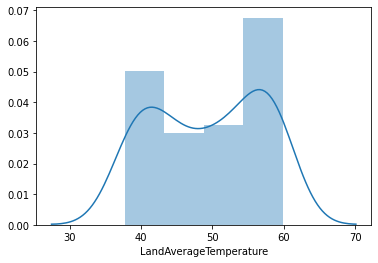

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.distplot(test["LandAverageTemperature"])

plt.show()

#**Metrics**

I want to use RMSE because my temperature prediction calls for my model to be as accurate as possible.